# Music Sentiment Analysis
### by Ben Pfeffer

In [1]:
from IPython.display import HTML

In [30]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this project is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Intro 
In this project I analyze the emotional content of music lyrics in the popular music of the US in the last 50 years. What emotions are expressed most commonly? Which emotions are less popular? Are different emotions correlated with one another? 

Keep in mind that I am only analyzing the emotional content of the *lyrics*, not the *melodies* in this project. Analyzing music while totally disregarding the melody is at best incomplete, so take everything you read here with a grain of salt. Sometimes the missing melody may be [amplifying](https://www.youtube.com/watch?v=4fWyzwo1xg0) the lyrical emotions. Other times the tune [contrasts](https://www.youtube.com/watch?v=unfzfe8f9NI) with the lyrics, acting as an emotional counterpoint or overriding the lyrics altogether. There is lots of research being done in the [interplay](https://www.researchgate.net/publication/247733383_Songs_and_emotions_Are_lyrics_and_melodies_equal_partners) between music and lyrics that warrants further investigation. This project can provide valuable insight into what emotions Americans are explicitly indulging in through their choice of lyrics, but even in the best case scenario this is only half the picture. 

This project was inspired by two data science projects I read about on the internet. The first is Greg Rafferty's [Sentiment Analysis on the Texts of Harry Potter](https://towardsdatascience.com/basic-nlp-on-the-texts-of-harry-potter-sentiment-analysis-1b474b13651d). The second is John W. Miller's [Trucks and Beer 🍺](https://www.johnwmillr.com/trucks-and-beer/). I decided to do a bit of a combination of the two, performing a similar sentiment analysis as Rafferty, but using Miller's Genius API wrapper to scrape lyrics from many musical artists. 

 The Billboard Hot 100 Artists is a year-end list of the most successful and prominent artists of the year. It measures record sales, radio airtime, and (for newer artists) internet streaming in the US. The lists for all years ranging between 1970 and 2019 are available online. For this reason I believe these lists will allow us to build a good sample of the most popular music in the US. One advantage to this approach is that it will allow us to get historical data from artists back before streaming was popular (Spotify wouldn't be able to tell us who people were listening to in the 70's). One limitation to this approach is that it only gives us data about the very top of the pyramid. There is tons of very popular music in the US made by artists who have never made a Billboard Hot 100 Artists list. There is a risk that the emotional content of many of those artist's lyrics is significantly different than the emotional content of the artists at the top. 


 ## Data Wrangling 
 To begin, I scrape the Billboard Hot 100 artists for each year from 1970 to 2019 using the BeautifulSoup package. Then I delete all the duplicates (for example, Michael Jackson is on the list for most years in the 80's). I am left with a list of 1540 musical artists who were popular in the US for at least one year between 1970 and 2019. Some are staples of popular music, while others are more one hit wonders. The code for this section is [here](https://github.com/ben-pfeffer/lyrics-sentiment/blob/master/scrape-artists.py). 
 
 Next, I want to gather the lyrics for the most popular songs by each artist. I use John W. Miller's Genius API wrapper to search for songs by each of the 1540 artists. I limit my search to the 25 most popular songs by each artist, as determined by the Genius algorithm. Many artists have fewer than 25 songs available, but for expediency's sake I do not search for every song by artists with more than 25 songs. The lyrics are cleaned to remove punctuation and stop words (words like "a," "the," "of," "and" etc), and convert everything to lower case. The code for this is [here](https://github.com/ben-pfeffer/lyrics-sentiment/blob/master/gather-lyrics.py).  
 
 It was convenient to write the previous section as a JSON file, but I want to work with a data frame, so after scraping I convert the JSON file to a CSV. The code for that piece is [here](https://github.com/ben-pfeffer/lyrics-sentiment/blob/master/json-to-csv.py).
 

## Methodology 
 Now that I have the artist and lyrics in a nicely formatted data frame, it is time to do the sentiment analysis. I use the [NRC Emotion Lexicon](https://nrc.canada.ca/en/research-development/products-services/technical-advisory-services/sentiment-emotion-lexicons) to ascribe emotions to musical lyrics. The NRC Lexicon has word-emotion associations for eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) as well as a general positive or negative sense. For example, the word "vindictive" is associated with "anger," "disgust," and "negative." The word "fondness" is associated with "joy" and "positive." Each word is scored either a 0 (not associated) or a 1 (associated) with each emotion. The lexicon has over 25,000 words classified in this way.
 
 For an artist in the data frame, I give them a scorecard for each emotion. I look at each word in the list of lyrics and cross reference the NRC lexicon for emotional associations. Any time there is a match I add a point to the appropriate emotion(s) for the artist. This process is repeated for each artist in the data frame. Since different artists have very different word counts, I divide the artist's score for each emotion by their total word count. This gives us a percentage of the artist's lyrics (after stop words are removed) associated with each emotion in the NRC lexicon. We also calculate the number of unique words and the lyrical diversity (unique words/total words) for each artist. 
 
 The code for this section is [here](https://github.com/ben-pfeffer/lyrics-sentiment/blob/master/sentiment-analysis.py). We start with 1540 artists and search for lyrics related to each of them. Some do not return anything, and we drop those artists. We are left with 1463 artists in our data frame. Below is the first five rows of our dataset. 
 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
%matplotlib inline

df = pd.read_csv('sentiment-data-clean.csv', index_col='index')

# store length of original df for use later
orig_len = len(df)
# display first 5 rows of df
df.head().round(5)

,Artist,Lyrics,Word Count,Unique Words,Lyrical Diversity,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
index,,,,,,,,,,,,,,,
0,O.T. Genasis,love coco coco love coco coco got low low love...,6304,1479,0.23461,0.06773,0.09343,0.08439,0.04775,0.03918,0.04711,0.05060,0.04727,0.04267,0.05282
1,Dean Lewis,look ground see sad teary eyes look away see s...,3331,564,0.16932,0.06334,0.09096,0.03392,0.04773,0.01411,0.04533,0.05374,0.05254,0.03032,0.02192
2,Edwin Starr,war huh yeah good absolutely nothing uhuh war ...,3359,749,0.22298,0.10777,0.05716,0.01667,0.05627,0.01250,0.04614,0.08038,0.03245,0.03096,0.06163
3,Cali Swag District,like smoove teach dougie know cause bitches lo...,7635,1676,0.21952,0.07950,0.10072,0.08527,0.03458,0.06012,0.06261,0.05239,0.05344,0.03982,0.05540
4,The Marshall Tucker Band,gonna take freight train station lord care goe...,2426,678,0.27947,0.09975,0.07090,0.02267,0.07131,0.03462,0.03009,0.06101,0.03627,0.02350,0.04823


## Data Cleaning 

One of the first visualizations I made gives two informative outliers. The graph below plots total Word Count against Unique Words. As you would expect, artists with higher word counts tend to have more unique words. Let's investigate the two outliers.

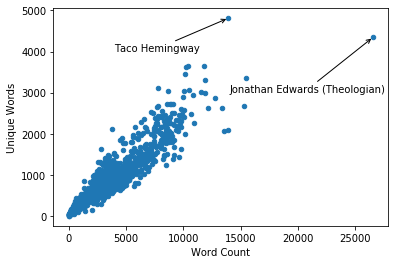

In [3]:
df.plot(kind='scatter', x='Word Count', y='Unique Words')
plt.annotate('Jonathan Edwards (Theologian)', xy=(26517, 4344), xytext=(14000, 3000),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate('Taco Hemingway', xy=(13903, 4810), xytext=(4000, 4000),
            arrowprops=dict(facecolor='black', arrowstyle='->'))
print('')

 Taco Hemingway has more unique words than any other artist, and much more than you would expect given his word count. The reason is because Hemingway is a Polish rapper. Polish presumably has more unique words than english, perhaps because of conjugations, but also because we did not remove Polish stop words. I also used a stemmer to convert words into their base words (for example, 'running' becomes 'run' and 'curtains' becomes 'curtain'), but this stemmer only went looking for English words and probably made no changes to the Polish words. The result is a disproportionately high unique word count. The emotion lexicon, likewise only recognizes English words, so we expect Taco Hemingway's lyrics to show up as unemotional. 

In [32]:
df.sort_values('Unique Words', ascending=False).head(1)

,Artist,Lyrics,Word Count,Unique Words,Lyrical Diversity,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
index,,,,,,,,,,,,,,,
889,Taco Hemingway,teraz porozmawiajmy pieniądzach zauważyliście ...,13903,4810,0.345968,0.009135,0.002733,0.003596,0.00374,0.000719,0.00151,0.00784,0.001151,0.007337,0.003668


Indeed, Hemingway's lyrics are scored as highly unemotional by the algorithm. 

Now, I have never heard of Taco Hemingway, and I was surprised a Polish rapper made it on an American hot music list. After some investigation, I confirmed that Taco Hemingway has never been on the Hot 100 Artists list, but there was an artist called Taco who had a hit in 1983 and made the list. Taco does not appear in my data. I think what happened was that when I queried the Genius API for Taco, it gave me the 25 most popular songs by any artist with Taco in their name, and Taco Hemingway happens to be more popular than the American Taco from the 80's. 

In the same way, I'm very certain that Jonathan Edwards, a theologian from the colonial era, did not make the Billboard Hot 100 in the last 50 years. There was a musical artist with the same name who had a hit in 1971. When I searched the Genius API it gave me data on the theologian, perhaps because the theologian has an audiobook that is more popular than the musician's songs. 

The code allows for gathering lyrics from artists that are close but not exact matches to the original artist. This is something that I would like to fix in a future version of this project, but for now I do not think it will skew the results so much that I need to re-code the project before we look at the results. Let's proceed with the analysis.

But first, I want to take a detour into the emotional content of Jonathan Edwards (Theologian). Since the "lyrics" data returned for Edwards is a chunk of his writing, he tallied up a far higher word count than any of the musicians. Since Edwards wrote in English we can take a look at how the algorithm ranked the emotionality of his work. 

Edwards is best known for his sermon "Sinners in the Hands of an Angry God."  The sermon is famous for its vivid imagery of hell and for scaring crowds of people into a sudden religious fervor. He is seen as representative of colonial Calvinist theology in his focus on describing heaven and hell as real, physical places. Edwards is credited with being a major figure in starting the First Great Awakening in US history. 

In [38]:
df.sort_values('Word Count', ascending=False).head(1)

,Artist,Lyrics,Word Count,Unique Words,Lyrical Diversity,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
index,,,,,,,,,,,,,,,
973,Jonathan Edwards (Theologian),deuteronomy xxxii 35 foot shall slide due time...,26517,4344,0.163819,0.156541,0.052645,0.023758,0.099144,0.021609,0.0712,0.087717,0.028397,0.030886,0.123921


The algorithm ranks Edwards highly on positivity, trust, anticipation, joy, and fear. Other negative emotions have low scores. Edward's sermons seem to be generally from human's perspective on heaven and hell, rather than from God's perspective. So it makes sense that emotions like anger, disgust, and sadness are deemphasized, as those would be more likely to be associated with God's feelings towards humans in Edward's theology. 

However, for someone who is primarily associated with his vivid hell imagery (“Unconverted men walk over the pit of hell on a rotten covering.”), I was surprised at how much more positivity is in his work (heaven) than negativity (hell). Overall, the emotional analysis seems like it roughly matches the themes of his work, so I take this as some confirmation that the algorithm is doing what it set out to do. 

We drop Edwards from the data since he is not a musician, but keep Taco Hemingway. We also drop any artist with fewer than 500 total words, as the small sample size may cause misleading results.

In [22]:
# we remove Jonathan Edwards the theologian
df = df[df.Artist !=  'Jonathan Edwards (Theologian)']

# we also remove artists with fewer than 500 unique words
# (small sample size artists may have randomly high emotion values)
df = df[df['Word Count'] > 500]

# how many entries have we removed in this way? 
removed_rows = orig_len - len(df)
print("Removed " + str(removed_rows) + " artists. " + str(len(df)) + " remaining.")

Removed 94 artists. 1369 remaining.


## Findings

Now let's find out whether positivity and negativity are expressed in equal amounts. We take each artist's overall positivity and negativity averages and plot them as a density function. Higher values on the curve mean more artists have an average at that level. 

The positive emotions mean is 0.088. 
The negative emotions mean is 0.068


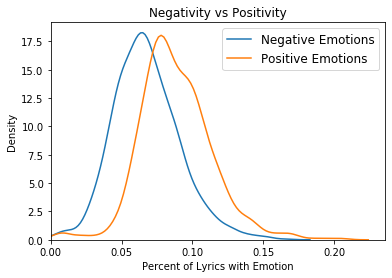

In [41]:
sns.distplot(df['negative'], hist=False, label='Negative Emotions')
sns.distplot(df['positive'], hist=False, label='Positive Emotions')
plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Negativity vs Positivity')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density')  

pos_mean = df['positive'].mean().round(3)
neg_mean = df['negative'].mean().round(3)

print('The positive emotions mean is ' + str(pos_mean) + 
      '. \nThe negative emotions mean is ' + str(neg_mean))

It certainly appears that positive emotions are expressed more often than negative emotions. We can use a two sample t-test to formalize this conclusion. 

In [59]:
t, p = stat.ttest_rel(df['positive'], df['negative'])
if p < 0.05:
    print('With a p-value of ' + str('{:0.2e}'.format(p)) +
          ', the difference in the means is statistically significant.')
elif p > 0.05:
    print('With a p-value of ' + str('{:0.2e}'.format(p)) + 
      ', the difference in the means is not statistically significant.')

With a p-value of 4.53e-78, the difference in the means is statistically significant.


The chance that we would see a result as extreme or more extreme than this one based just on random luck is vanishingly small. The mean increase--from 0.068 to 0.086--is almost a 30% increase, and this difference seems to be fairly uniform throughout the distribution. We can conclude that positive emotions are expressed about 30% more often than negative emotions in our population. 

Now let's take a closer look at the individual emotions. We'll start with the negative emotions. 

Anger mean: 0.03
Disgust mean: 0.022
Fear mean: 0.037
Sadness mean: 0.039


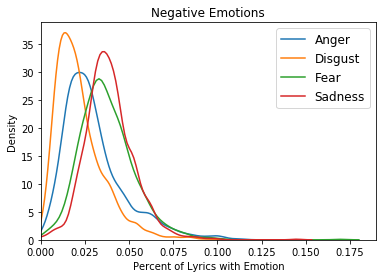

In [46]:
sns.distplot(df['anger'],   hist=False, label='Anger')
sns.distplot(df['disgust'], hist=False, label='Disgust')
sns.distplot(df['fear'],    hist=False, label='Fear')
sns.distplot(df['sadness'], hist=False, label='Sadness')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Negative Emotions')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density')

anger_mean = df['anger'].mean().round(3)
disgust_mean = df['disgust'].mean().round(3)
fear_mean = df['fear'].mean().round(3)
sadness_mean = df['sadness'].mean().round(3)

print('Anger mean: ' + str(anger_mean) + 
     '\nDisgust mean: ' + str(disgust_mean) + 
     '\nFear mean: ' + str(fear_mean) + 
     '\nSadness mean: ' + str(sadness_mean))

Disgust seems to be the least commonly expressed of the negative emotions. We will use a statistical test to ensure that we can be confident this is not just random noise, but first let's take a look at the positive emotions. 

Joy mean: 0.059
Surprise mean: 0.027
Anticipation mean: 0.052
Trust mean: 0.046


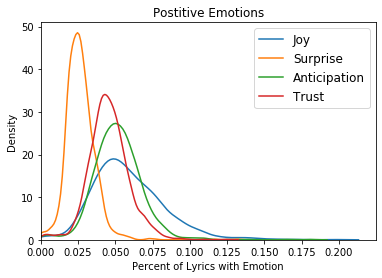

In [47]:
sns.distplot(df['joy'], hist=False, label='Joy')
sns.distplot(df['surprise'], hist=False, label='Surprise')
sns.distplot(df['anticipation'], hist=False, label='Anticipation')
sns.distplot(df['trust'], hist=False, label='Trust')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Postitive Emotions')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density') 

joy_mean = df['joy'].mean().round(3)
surprise_mean = df['surprise'].mean().round(3)
anticipation_mean = df['anticipation'].mean().round(3)
trust_mean = df['trust'].mean().round(3)

print('Joy mean: ' + str(joy_mean) + 
     '\nSurprise mean: ' + str(surprise_mean) + 
     '\nAnticipation mean: ' + str(anticipation_mean) + 
     '\nTrust mean: ' + str(trust_mean))

We would like to investigate whether the observed differences in the means for each of the emotions are significantly different. Standard statistical practice is to run an ANOVA test first. This will tell us whether any of the emotion pairs have significantly different means, or whether all the variation is plausibly attributable to random noise.

In [62]:
# ANOVA test
f, p = stat.f_oneway(df['joy'], 
                     df['surprise'],
                     df['anticipation'],
                     df['trust'],
                     df['anger'],
                     df['disgust'],
                     df['fear'],
                     df['sadness'])
if p < 0.05:
    print('The p-value for the ANOVA test is ' + str(p) + 
          '. This is a statistically significant value. \nWe conclude that there is at least one ' +
         'significant difference between the means.')
elif p > 0.05:
    print('The p-value for the ANOVA test is ' + str(p) + 
          '. This is not a statistically significant value. \nThe difference in the means ' + 
          'may be due to random noise.')

The p-value for the ANOVA test is 0.0. This is a statistically significant value. 
We conclude that there is at least one significant difference between the means.


 The ANOVA test affirms that at least one pair is significantly different, but it does not tell us which pair or pairs are significant. We use the Pairwise Tukey HSD test to test all emotion pairs, because this test will automatically adjust our p-values to control the type I error rate. 

In [49]:
# reshape the d dataframe suitable for statsmodels package 
df_melt = pd.melt(df.reset_index(), id_vars=['Artist'], 
                   value_vars = ['joy', 'surprise','anticipation', 'trust',
                                 'anger','disgust','fear','sadness'])

# replace column names
df_melt.columns = ['Artist', 'Emotion', 'value']

multi_comp = pairwise_tukeyhsd(endog=df_melt['value'], groups=df_melt['Emotion'], 
                               alpha=0.05)
print(multi_comp)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
       anger anticipation   0.0212  0.001  0.0193   0.023   True
       anger      disgust  -0.0084  0.001 -0.0103 -0.0066   True
       anger         fear   0.0072  0.001  0.0053   0.009   True
       anger          joy   0.0282  0.001  0.0263  0.0301   True
       anger      sadness   0.0086  0.001  0.0067  0.0104   True
       anger     surprise  -0.0038  0.001 -0.0057 -0.0019   True
       anger        trust   0.0152  0.001  0.0134  0.0171   True
anticipation      disgust  -0.0296  0.001 -0.0315 -0.0278   True
anticipation         fear   -0.014  0.001 -0.0159 -0.0122   True
anticipation          joy    0.007  0.001  0.0052  0.0089   True
anticipation      sadness  -0.0126  0.001 -0.0145 -0.0108   True
anticipation     surprise   -0.025  0.001 -0.0268 -0.0231   True
anticipation        trust

All pairwise comparisons are statistically significant (denoted by "True" in the rightmost column) except for fear-sadness. The means of all other emotion pairs are due to underlying differences in the amounts they are expressed; random noise is an implausible explanation. We can conclude that joy and anticipation have the highest rates of expression in US popular music of the last 50 years. Disgust and surprise are the least commonly expressed. 

However, statistical significance is not the same as practical significance. With our large sample size it is very possible that we are detecting statistical significance that the average person would never notice. For example, look at the disgust-surprise pair. The difference in their means is only 0.0046. For the average artist, surprise appears in 2.7% of lyrics and disgust appears in 2.2% of lyrics. Would the average music listener really notice a difference? Let's unpack that question.

While the means of disgust and surprise are very close, the shapes of the distributions are somewhat different. This is something that the statistical test will not pick up, but is worth discussing.


Surprise mean: 0.027
Disgust mean: 0.022


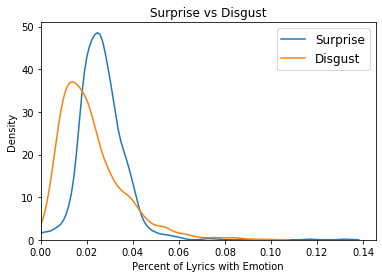

In [50]:
sns.distplot(df['surprise'], hist=False, label='Surprise')
sns.distplot(df['disgust'], hist=False, label='Disgust')

plt.xlim(0, None)
plt.legend(prop={'size': 12})
plt.title('Surprise vs Disgust')
plt.xlabel('Percent of Lyrics with Emotion')
plt.ylabel('Density') 

print('Surprise mean: ' + str(surprise_mean) +
      '\nDisgust mean: ' + str(disgust_mean))

The peaks of the two distributions (the most likely values to occur) are further apart than their means (that is, the center of mass for the curve).

The distribution of surprise is tall and symmetrical. We see that almost every artist displays surprise in between 1.5% and 4% of their lyrics. This matches with my intuition on the nature of surprise. Nobody can be surprised very often (otherwise it wouldn't be much of a surprise), but everybody is surprised sometimes (otherwise they would have to always be right or else not think at all about the future).

Disgust, on the other hand, has a wider distribution with a right skew. Some artists almost never display disgust. Others are disgusted quite often. Eight artists emote disgust with more than 8% of their lyrics.

In [13]:
x = df.sort_values('disgust', ascending=False).head(9)
x[['Artist', 'Lyrics','disgust']].set_index('Artist')

,Lyrics,disgust
Artist,,
Khalid & Normani,sorry hard catch vibe mmm need lover trust tel...,0.098676
Sheck Wes,16yrold bitch daytrip took 10 got hoes callin ...,0.092721
Cornelius Brothers & Sister Rose,mama told said son please beware thing called ...,0.087649
Miami Sound Machine,come shake body baby conga know control longer...,0.084741
Megan Thee Stallion,real hot girl shit yeah bag every time see got...,0.083894
Famous Dex,hey yo big bro fucking ha okay cool good job 1...,0.083434
21 Savage & Metro Boomin,ten bad bitches mansion wrist milly rock diamo...,0.083103
Trinidad James,shit sound like 007 n64 shit yeah yeah yeah ye...,0.080311
Lil Reese,really talking bitch bout action bout life man...,0.076416


Forty-six artists emote disgust with less than 0.5% of their lyrics (to be fair, it looks like eleven of those artists have an artificially low ratio because their lyrics are in a different language).

In [20]:
x = df.sort_values('disgust', ascending=True).head(45)
x[['Artist', 'Lyrics','disgust']].set_index('Artist')

,Lyrics,disgust
Artist,,
McFadden & Whitehead,ready ready gonna fever yeah come stoppin us m...,0.000000
William DeVaughn,though may drive great big cadillac gangsta wh...,0.000000
B.T. Express,oooooo go til satisfied whatever til satisfied...,0.000000
Макс Корж (Max Korzh),поздний вечер из окна на кухне тени зажигают с...,0.000000
​the Chemodan Clan,на зубах не фиксы фиксы на минус ложатся выхва...,0.000258
George McCrae,sexy woman woman take arms rock baby woman tak...,0.000429
Taco Hemingway,teraz porozmawiajmy pieniądzach zauważyliście ...,0.000719
MFSB,love message love love love woo hoo doo doo do...,0.001029
Nu Shooz,baby wait love tell got something live without...,0.001519


This also matches my intuition. Some people are very rarely dsgusted. They seem to accept most things as they are. Others are disgusted quite often. They may demand some sort of change.

The fact that the algorithm picked up these differences in distributions that match with basic intuition about how human emotions work gives me confidence that the algorithm is doing what it was disigned to do.

As to the original question of whether people would notice a practical difference in the amount of disgust and surprise in their music, my suspicion is that it depends on the person. I would think that people would tend to gravitate to music with higher or lower levels of disgust to match their personal preferences. Surprise, on the other hand, seems more universal and harder to pick and choose. It seems likely to me that some people are exposed to more disgust than surprise in their music, while others are exposed to more surprise than disgust, and that people have some degree of agency in selecting music that matches their preferences. 

As a final point of exploration, let's look at the correlations between all the different emotions. Which emotions are strongly correlated? 


In [51]:
df.corr().style.background_gradient(cmap='coolwarm', axis=None, low=.25).set_precision(2)

,Word Count,Unique Words,Lyrical Diversity,positive,negative,anger,anticipation,disgust,fear,joy,sadness,surprise,trust
Word Count,1.00,0.90,-0.30,-0.42,0.34,0.50,-0.43,0.44,0.28,-0.45,0.08,-0.12,-0.22
Unique Words,0.90,1.00,0.07,-0.38,0.35,0.48,-0.34,0.44,0.27,-0.46,0.08,-0.07,-0.12
Lyrical Diversity,-0.30,0.07,1.00,0.07,0.02,-0.03,0.17,0.00,-0.03,-0.05,-0.02,0.10,0.22
positive,-0.42,-0.38,0.07,1.00,-0.23,-0.29,0.59,-0.21,-0.18,0.91,-0.01,0.37,0.67
negative,0.34,0.35,0.02,-0.23,1.00,0.81,-0.11,0.80,0.82,-0.31,0.74,0.23,0.04
anger,0.50,0.48,-0.03,-0.29,0.81,1.00,-0.22,0.84,0.72,-0.37,0.54,0.18,-0.04
anticipation,-0.43,-0.34,0.17,0.59,-0.11,-0.22,1.00,-0.21,-0.03,0.61,0.05,0.56,0.62
disgust,0.44,0.44,0.00,-0.21,0.80,0.84,-0.21,1.00,0.64,-0.30,0.57,0.17,0.02
fear,0.28,0.27,-0.03,-0.18,0.82,0.72,-0.03,0.64,1.00,-0.24,0.71,0.24,0.05
joy,-0.45,-0.46,-0.05,0.91,-0.31,-0.37,0.61,-0.30,-0.24,1.00,-0.03,0.36,0.57


###### **Keep in mind that correlation is not causation!**
Here are a few of the tidbits I found interesting from this chart.

- Word Count and Unique Words are moderately correlated with anger and disgust, and moderately inversely correlated with joy. More words: more anger and disgust, and less joy
- Lyrical Diversity (that is, Unique Words/Word Count) is not strongly correlated with any emotion
- The positive emotions are correlated with other positive emotions. The negative emotions are correlated with other negative emotions
- The positive and negative emotions do not have a very strong inverse correlation with each other. The positive correlations are stronger than the negative correlations. The presence of negativity does not imply a lack of positivity, and vice versa. Jonathan Edwards talks a lot about hell, but also a lot about heaven
- The strongest inverse correlation is between joy and Unique words. Other positive emotions have negative correlations to Word Cound and Unique Words. The happier artists say less

## Conclusion
I would like to suggest some improvements and follow up projects to build on this one. 
- tweak the Genuis API search function to make sure we get the right artists (Jonathan Edwards, Theologian)
- discard artists and lyrics who primarily perform in non-English languages (Taco Hemingway)
- scrape the Billboard Top 100 Songs per year (this project scraped the Hot 100 Artists). With this data you could track the emotional content of popular song lyrics over time. 
    - Which emotions are more prevalent in which time periods? 
    - Do we see an increase in negative emotional content during recessions, wartime, or other difficult historical periods? Which negative emotions?
- Pick one artist with a lage discography. Emotionally classify each of their albums 
    - eg. how has the emotional composition of Beyonce's lyrics changed throughout her career? 
- Find a way to analyze the emotional content of the melody. Combine this analysis with a lyrical analysis
